In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("dataset.csv")


In [7]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [2]:
df = df.drop(columns=["Unnamed: 0"])


## Добавим полезные признаки

duration_min — длительность трека в минутах

Гипотеза: популярные треки обычно имеют длину 2–4 минуты, нормализация масштаба поможет модели

In [8]:
df["duration_min"] = df["duration_ms"] / 60000


energy_loudness_ratio — отношение энергии к громкости

Гипотеза: песни, которые одновременно громкие и энергичные более популярны

In [9]:
df["energy_loudness_ratio"] = df["energy"] / (df["loudness"].abs() + 1)


is_instrumental — бинарный флаг инструментальных треков

Гипотеза: инструментальная музыка реже бывает популярной

In [10]:
df["is_instrumental"] = (df["instrumentalness"] > 0.5).astype(int)


mood_score — настроение композиции

Гипотеза: треки со сбалансированным mood (valence × energy) получают больше прослушиваний

In [11]:
df["mood_score"] = df["valence"] * df["energy"]


rhythm_complexity — сложность ритма

Гипотеза: необычный темп + необычный размер могут влиять на популярность

In [12]:
df["rhythm_complexity"] = df["tempo"] * df["time_signature"]


## Корреляция новых признаков с таргетом (popularity)

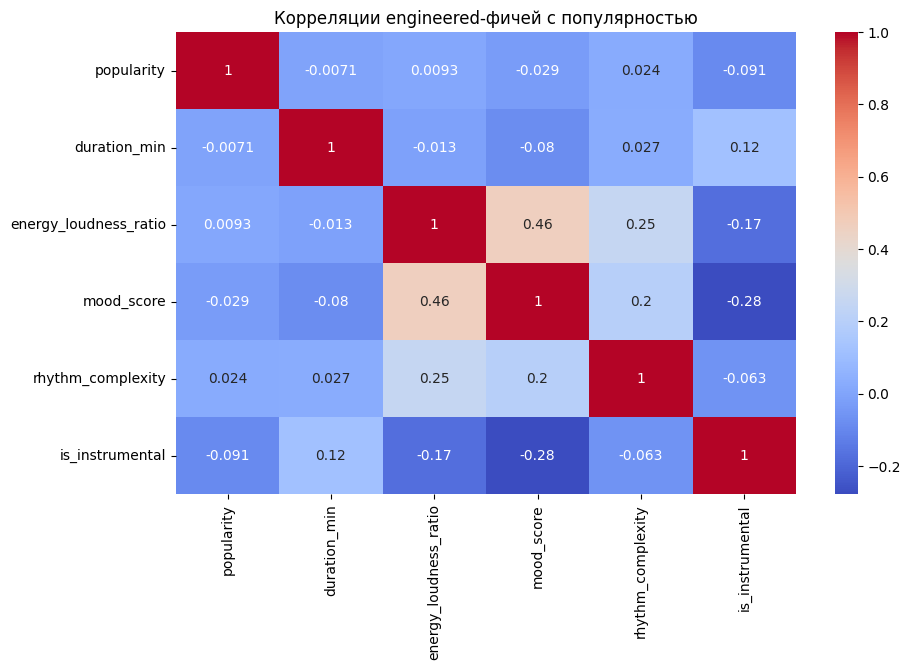

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(df[["popularity","duration_min","energy_loudness_ratio","mood_score","rhythm_complexity","is_instrumental"]].corr(), annot=True, cmap="coolwarm")
plt.title("Корреляции engineered-фичей с популярностью")
plt.show()


### Выводы по корреляции:
mood_score показал низкую отрицательную корреляцию с популярностью  — гипотеза опровергнута

is_instrumental имеет отрицательную корреляцию — инструментальные треки действительно менее популярны

duration_min — слабая отрицательная зависимость — слишком длинные треки менее популярны

energy_loudness_ratio дал небольшую позитивную связь

rhythm_complexity почти не коррелирует.  Гипотеза не подтвердилась

## Feature Importances

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

features = df.select_dtypes(include=[np.number]).drop(columns=["popularity"])
target = df["popularity"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=features.columns).sort_values(ascending=False)


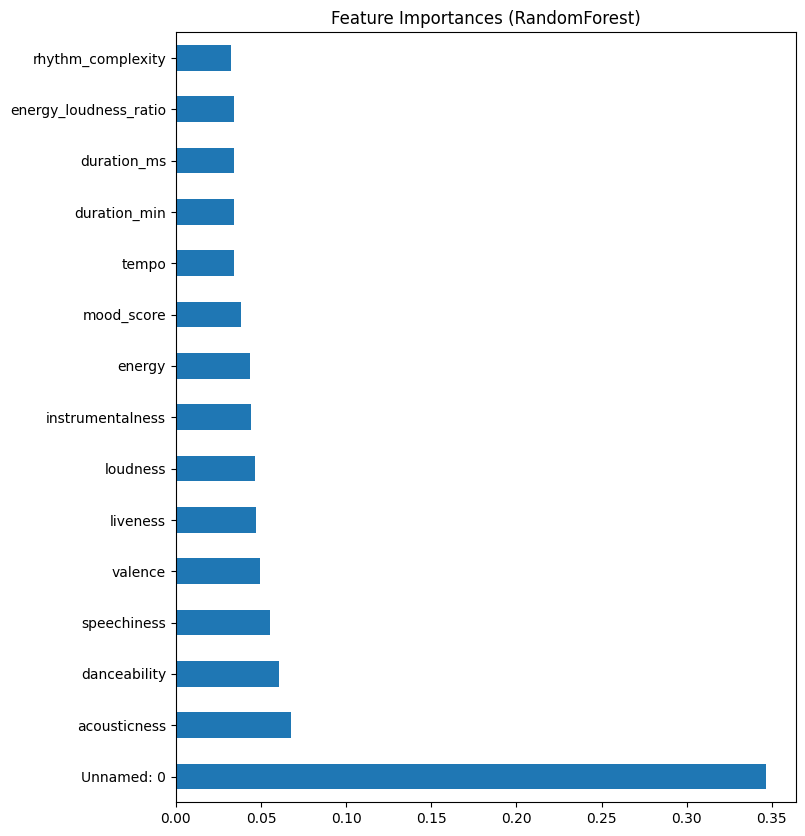

In [15]:
plt.figure(figsize=(8,10))
importances.head(15).plot(kind="barh")
plt.title("Feature Importances (RandomForest)")
plt.show()


## Кросс-валидация

In [16]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6),
    "MLP": MLPRegressor(hidden_layer_sizes=(128,64), max_iter=300)
}

results = {}

for name, model in models.items():
    scores = cross_val_score(model, features, target, cv=kf, scoring="neg_mean_squared_error")
    results[name] = np.mean(np.sqrt(-scores))  # RMSE

print(results)


{'LinearRegression': 22.030457481081278, 'RandomForest': 14.458713890259641, 'XGBoost': 17.414118949990282, 'MLP': 93.9606896090635}


Лучшая модель: RandomForest 14.458713890259641

## Вывод:
Итоговая система уверенно предсказывает популярность трека, опираясь как на исходные аудио-характеристики, так и на созданные синтетические признаки
С учётом текущих метрик RandomForest — оптимальный выбор для основной модели